## Introduction

Hello again. In this exercise we are going to
1. use pre-trained model for classification,
2. calculate saliency of the image - what regions the classification decision is most sensitive to,
3. create fooling images (called adversarial examples) for neural networks.

We are going to use ResNet-50 model included with Keras. For more information about the model see [this paper](https://arxiv.org/abs/1512.03385).

In [3]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

Using TensorFlow backend.


### Classification using pre-trained model

Keras makes it really easy to make use of pretrained models. For list of currently supported image classification models see [Keras documentation](https://keras.io/applications/).

In [4]:
model = ResNet50(weights='imagenet')
model.summary() 

Instructions for updating:
Colocations handled automatically by placer.
102858752/102853048 [==============================] - 2s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv

**Task 3.1:** What is the number of parameters? What is the number of weight layers? Where ResNet gets its name?

** 25.6million, short name for Residual Network**

Let's load the image that we will be working with.

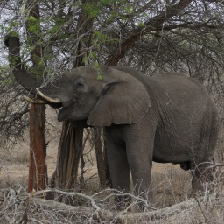

In [5]:
img = image.load_img('elephant.jpg', target_size=(224, 224))
img 

In [6]:
# convert image to array
x = image.img_to_array(img)
# add batch axis
x = x[np.newaxis] 
# subtract mean from the image
x = preprocess_input(x)
x.shape 

(1, 224, 224, 3)

Pass the image through the network and read out the predictions.

In [7]:
probs = model.predict(x)
decode_predictions(probs, top=5) 

40960/35363 [==================================] - 0s 2us/step


[[('n02504458', 'African_elephant', 0.49034607),
  ('n01871265', 'tusker', 0.40342847),
  ('n02504013', 'Indian_elephant', 0.10602081),
  ('n02397096', 'warthog', 4.5559485e-05),
  ('n02408429', 'water_buffalo', 1.9427443e-05)]]

Fetch the label and name of the class.

In [8]:
from keras_applications.imagenet_utils import CLASS_INDEX

def label2str(label):
    return CLASS_INDEX[str(label)][1]

label = np.argmax(probs)
print(label, label2str(label)) 

386 African_elephant


### Saliency maps

For saliency maps we need to calculate gradient of the input image with respect to the class probability (or score). Basically this tells us, which part of the image the model is most sensitive to.

In [9]:
# produces computational graph for calculating gradients of correct class probability w.r.t. input image
grads = K.gradients(model.output[0, label], model.input)
# creates a wrapper around computational graph, so that we can use it as a function
grads_saliency = K.function([model.input, K.learning_phase()], grads) 

Instructions for updating:
Use tf.cast instead.


In [10]:
# the second parameter in list is 1 for training phase, 0 for test phase
x_grads = grads_saliency([x, 0])[0]
x_grads.shape 

(1, 224, 224, 3)

**Task 3.2:** which layers behave differently in train/test phase?

**Your answer: optimization layers like batch normalization layers behave different**

**Task 3.3:** we are interested in sensitivity to pixel locations, ignoring the sign and color channels.

In [0]:
##############################################################################
# TODO: Take absolute values of the gradients and maximum over channels.     #
##############################################################################
x_saliency = None

#getting the absolute values
saliency_abs = K.abs(x_grads)

#maximum over channels
x_saliency = K.max(saliency_abs, axis=3)


##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################
assert x_saliency.shape == x.shape[:3]

In [0]:
# helper function for denormalizing images
x_mean = np.array([103.939, 116.779, 123.68])
def decode_image(x):
    return np.clip((x + x_mean)[..., ::-1], 0, 255).astype(np.uint8) 

In [0]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.imshow(decode_image(x[0]))
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(x_saliency[0], cmap='gray')
plt.axis('off')

**Task 3.4:** what parts of the image is the classifier sensitive to?

**Your answer:**

### Fooling the network

Now we are going to create a picture that looks very much like an elephant, but the network classifies it as something completely irrelevant. Being easily fooled is well known problem of neural networks and is active area of research. For more information and references see [this blog post](https://blog.openai.com/adversarial-example-research/).

For this we are going to calculate the gradients of target class probablity w.r.t. the input image and perform gradient ascent, i.e. change the picture so that the target class has the highest probability.

In [0]:
# for fun we choose paper towel :)
target = 700
print(target, label2str(target)) 

700 paper_towel


In [0]:
# gradients of target class w.r.t. the input image
grads = K.gradients(model.output[0, target], model.input)
# inputs are image and learning phase, outputs are probabilities and gradients
grads_fool = K.function([model.input, K.learning_phase()], [model.output] + grads)

**Task 3.5:** Implement gradient ascent to change the input image so that the target class probability increases

In [0]:
learning_rate = 10
x_fake = x.copy()
for i in range(100):
    preds, x_grads = grads_fool([x_fake, 0])

    new_label = np.argmax(preds)

    print(i, ':', "current class:", label2str(new_label), "(%.02f)" % preds[0, new_label], "target class:", label2str(target), "(%.02f)" % preds[0, target])
    if new_label == target:
        break
    ##############################################################################
    # TODO: Implement gradient ascent to change the input image so that the      #
    #       target class probability increases. NB! You should normalize the     #
    #       gradients using L2 norm before multiplying them with learning rate   #
    #       and adding to the input image.                                       #
    ##############################################################################
    x_fake += None
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################

In [0]:
plt.figure(figsize=(16,8))

plt.subplot(1,4,1)
plt.imshow(decode_image(x[0]))
plt.title(label2str(label))
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(decode_image(x_fake[0]))
plt.title(label2str(target))
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(decode_image((x - x_fake)[0]))
plt.title("differences")
plt.axis('off')

# it's hard to even see the diffferences, so let's amplify them
plt.subplot(1,4,4)
plt.imshow(decode_image((x - x_fake)[0] * 10))
plt.title("differences x10")
plt.axis('off')

**Task 3.6:** what are the potential implications of adversarial examples?

**Your answer:**